In [5]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [6]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [7]:
# Hyperparameters
BUFFER_SIZE = 1000000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.001
CRITIC_LEARNING_RATE = 0.001
ACTOR_LEARNING_RATE = 0.0001
EXPLORATION = 0.1

# Create environment
env = gym.make('LunarLanderContinuous-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_max = env.action_space.high[0]

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
# Actor network
class Actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        self.fc3 = layers.Dense(action_dim, activation='tanh')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x * action_max

# Critic network
class Critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        self.fc3 = layers.Dense(1)

    def call(self, state, action):
        x = tf.concat([state, action], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [9]:
# Replay buffer
class ReplayBuffer():
    def __init__(self):
        self.buffer = []
        self.max_size = BUFFER_SIZE

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size=batch_size, replace=False)
        state, action, reward, next_state, done = [], [], [], [], []
        for i in index:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.float32)

In [20]:
# DDPG agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, critic_lr=1e-3, actor_lr=1e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.target_actor = self.build_actor()
        self.target_critic = self.build_critic()
        self.replay_buffer = ReplayBuffer()
        self.total_reward = []
        self.avg_reward = []
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)


    def build_actor(self):
        input_layer = tf.keras.layers.Input(shape=(self.state_dim,))
        x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(self.action_dim, activation='tanh')(x)
        return tf.keras.Model(inputs=input_layer, outputs=output_layer)

    def build_critic(self):
        state_input = tf.keras.layers.Input(shape=(self.state_dim,))
        action_input = tf.keras.layers.Input(shape=(self.action_dim,))
        x = tf.keras.layers.concatenate([state_input, action_input])
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(1)(x)
        return tf.keras.Model(inputs=[state_input, action_input], outputs=output_layer)

    def get_action(self, state, exploration=0.1):
        actions = self.actor(tf.convert_to_tensor([state], dtype=tf.float32))
        action_max = env.action_space.high[0]
        action_dim = env.action_space.shape[0]
        actions += tf.random.normal(shape=[action_dim], mean=0.0, stddev=exploration)
        actions = tf.clip_by_value(actions, -action_max, action_max)
        return actions[0]

        
    def train(self, episodes=1000, steps_per_episode=200):
        for episode in range(episodes):
            state = env.reset()
            episode_reward = 0
            for step in range(steps_per_episode):
                action = self.get_action(state, exploration=EXPLORATION)
                next_state, reward, done, _ = env.step(action)

                self.replay_buffer.add(state, action, reward, next_state, done)
                if len(self.replay_buffer.buffer) >= BATCH_SIZE:
                    state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(BATCH_SIZE)
                    self.train_critic(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
                    self.train_actor(state_batch)

                state = next_state
                episode_reward += reward
                if done:
                    break

            self.total_reward.append(episode_reward)
            self.avg_reward.append(np.mean(self.total_reward[-100:]))
            print("Episode: {}, Total Reward: {:.2f}, Average Reward (last 100 episodes): {:.2f}".format(episode + 1, episode_reward, self.avg_reward[-1]))

            self.update_target_networks()

    def train_actor(self, state_batch):
        with tf.GradientTape() as tape:
            action_batch = self.actor(state_batch)
            q_values = self.critic([state_batch, action_batch])
            actor_loss = -tf.math.reduce_mean(q_values)
        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))

    def train_critic(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch)
            target_q_values = self.target_critic([next_state_batch, target_actions])
            y = reward_batch + (1 - done_batch) * GAMMA * target_q_values
            q_values = self.critic([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - q_values))
        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

    def update_target_networks(self):
        for source, target in zip(self.actor.variables, self.target_actor.variables):
            target.assign(TAU * source + (1 - TAU) * target)
        for source, target in zip(self.critic.variables, self.target_critic.variables):
            target.assign(TAU * source + (1 - TAU) * target)

In [21]:
# Define hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 0.005  # for soft update of target parameters
CRITIC_LR = 1e-3  # learning rate for the critic optimizer
ACTOR_LR = 1e-4  # learning rate for the actor optimizer


Episode: 1, Total Reward: -7.72, Average Reward (last 100 episodes): -7.72


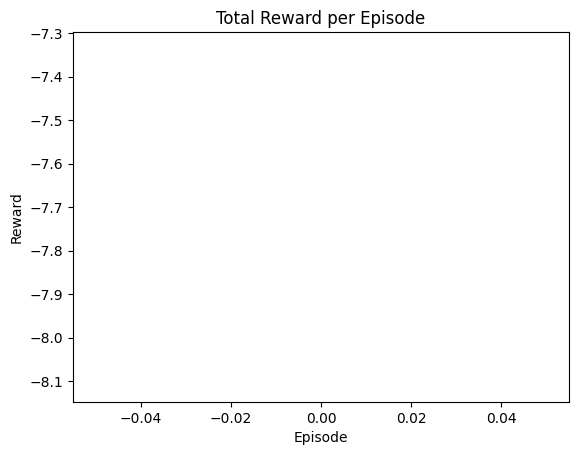

In [23]:
# Train the agent
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = DDPGAgent(state_dim, action_dim, critic_lr=CRITIC_LR, actor_lr=ACTOR_LR)
agent.train()

# Plot the total reward per episode
import matplotlib.pyplot as plt

plt.plot(agent.total_reward)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()
plt.savefig("DDPG_LunarLander_Total_Rewards.png")

# **Testing agent for 20 episodes**

Episode 1: Total Reward = -139.43213274818874


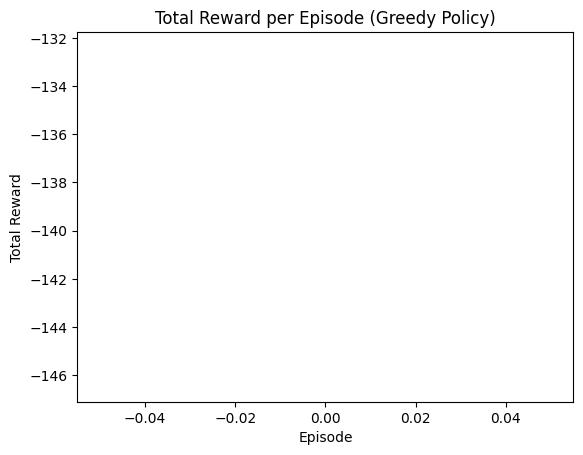

In [25]:
# Test the agent
total_rewards = []
for i in range(20):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.get_action(state, False)  # Choose greedy action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
    total_rewards.append(total_reward)
    print("Episode {}: Total Reward = {}".format(i+1, total_reward))

# Plot the total reward per episode
plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Greedy Policy)")
plt.show()
plt.savefig("DDPG_LunarLander_Testing_Rewards.png")